### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x000001CA755400D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 2: Pre-processing and data exploration

ASSUMPTION: run *01_Feature_extraction_exploration.ipynb* for datasets ESC-10, BDLib2 and US8k

***

## Importe modules

In [2]:
import mimetypes
import warnings
import os
import librosa
import random
import pickle

import pandas          as pd
import numpy           as np
import seaborn         as sns
import IPython.display as ipd

from tqdm        import tqdm
from matplotlib  import pyplot as plt

In [3]:
mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '02_PreProcessing_modeling_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

# Values for feature extraction
threshold   = 60
frames      = 44

In [5]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

## Loading the dataset


In [6]:
# Select the dataset

opc = 0
while str(opc) not in '123':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = 1
    time_length = 5
    dog_set     = 'Dog bark'
    windowingNo = 9
    
    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'
    
    aug_set  = True
    wind_set = True

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    time_length = 10
    dog_set     = 'dogs'
    windowingNo = 19

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'
    
    aug_set  = True
    wind_set = True

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
        
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    time_length = 4
    dog_set     = 'dog_bark'
    windowingNo = 7
    
    aug_set  = False
    wind_set = True
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K

Select the dataset: 3


In [7]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [8]:
from MT_loadDataset import loadDataset

In [9]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K

Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total number of unique files..........:  8732
Total number of AUDIO files...........:  8732


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


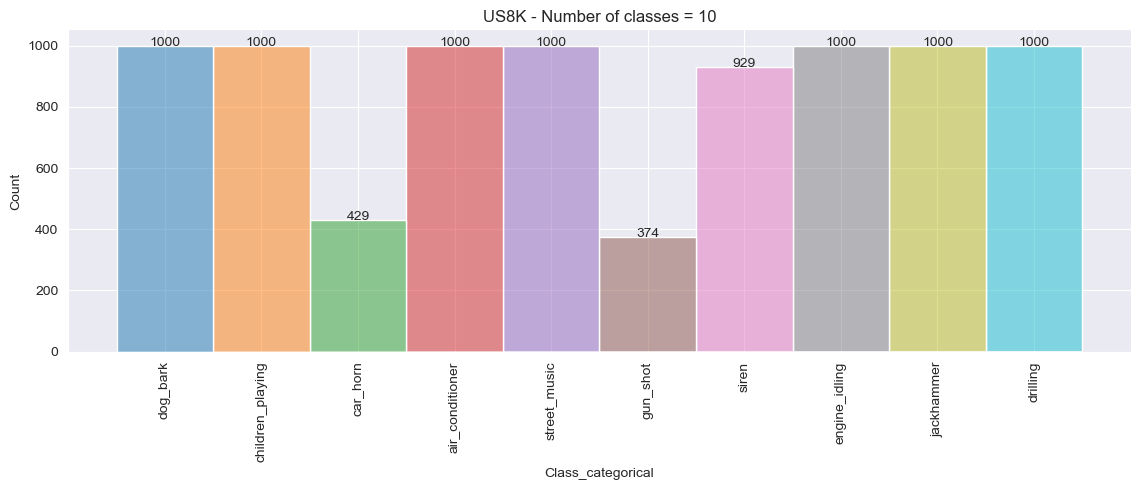

In [10]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

## Pre-processing the data (Features extraction)

### Exploratory code that lead to a class for extracting the features

Hand crafting the features into the dataframe

In [11]:
os.chdir(path)

In [12]:
pwd

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\US8K'

In [13]:
# Group by the class and get one random sample of each class
k = DB.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical      
air_conditioner    7796    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
car_horn           7505    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   8343    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           7487    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
drilling           4260    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
engine_idling      695     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
gun_shot           3620    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
jackhammer         3588    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
siren              532     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
street_music       7473    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'air_conditioner': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'car_horn': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'children_playing': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'dog_bark': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'drilling': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'engine_idling': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'gun_shot': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'jackhammer': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'siren': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'street_music': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [14]:
type(DB['Class_OHEV'][0][0])

int

In [15]:
encoder_dict[dog_set]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [16]:
DB

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


In [17]:
# Testing a method to parse each row and extract the defined audio feature

def feature_parser(row): 
    # Number of MFCCs and MELs
    n_mfcc = 13
    n_mels = 128
    
    # Load the audio file using "kaiser_fast" resampling method, otherwise use sr = 44100
    x, srate = librosa.load(row.Path, sr = SR)

    # Extract the features: RMS, ZCR 
    row['RMSE']      = np.mean(librosa.feature.rms(y                = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['ZCR']       = np.mean(librosa.feature.zero_crossing_rate(y = x, hop_length = HOP_LENGTH, frame_length = FRAME_SIZE))
    row['CENTROIDS'] = np.mean(librosa.feature.spectral_centroid(y  = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['BANDWIDTH'] = np.mean(librosa.feature.spectral_bandwidth(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    row['ROLLOFF']   = np.mean(librosa.feature.spectral_rolloff(y   = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate))
    
    # 128 x frames matrix
    mel              = librosa.feature.melspectrogram(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.mean(mel[i])
    
    # 13 x frames matrix
    mfcc             = librosa.feature.mfcc(y = x, sr = srate, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.mean(mfcc[i])

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.mean(spec_contrast[i])
    
    # 12 x frames matrix
    chroma           = librosa.feature.chroma_stft(y = x, hop_length = HOP_LENGTH, n_fft = FRAME_SIZE, sr = srate)
    chroma_sp        = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.mean(chroma[i])
    
    # 6 x frames matrix
    tonnetz          = librosa.feature.tonnetz(y = librosa.effects.harmonic(x), sr = srate)
    tonnetz_sp       = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.mean(tonnetz[i])
    
    return row

In [18]:
print("Frame size...: ", FRAME_SIZE)
print("Hop lenght...: ", HOP_LENGTH)
print()
tqdm.pandas()

DB = DB[0:20].progress_apply(feature_parser, axis = 1)

Frame size...:  1024
Hop lenght...:  512



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


In [19]:
for col in DB.columns:
    print(col)

Fold
Folder_name
Class_OHEV
Class_categorical
File_name
Path
classID
fsID
start
end
salience
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
ME

## Pre-processing the data (Features extraction)

Hand crafting the features into the dataframe

ATTENTION, setting the options *aug = True* and *windowing = True* together requires a lot of RAM.

With 64GB RAM, it's possible to use them in the datasets ESC-10 and BDLib2, but not in US8K.

In [20]:
db = pd.read_csv(os.path.join(path, csv_file))
db = db.drop('Unnamed: 0', axis=1)
db

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


In [21]:
type(db['Class_OHEV'][0])

str

In [22]:
dog = db[db['Class_categorical'] == dog_set]
dog

,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
14,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100652-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\100652-3-0-0.wav,3,100652,0.000000,4.000000,1
15,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100652-3-0-1.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\100652-3-0-1.wav,3,100652,0.500000,4.500000,1
16,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100652-3-0-2.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\100652-3-0-2.wav,3,100652,1.000000,5.000000,1
17,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100652-3-0-3.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\100652-3-0-3.wav,3,100652,1.500000,5.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8594,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,97193-3-0-4.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\97193-3-0-4.wav,3,97193,2.000000,6.000000,1
8595,2,fold2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,97193-3-0-6.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold2\97193-3-0-6.wav,3,97193,3.000000,7.000000,1
8611,6,fold6,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,97392-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold6\97392-3-0-0.wav,3,97392,0.000000,2.773946,1
8618,10,fold10,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,97756-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold10\97756-3-0-0.wav,3,97756,0.141727,1.290466,1


In [23]:
random_idx = random.choice(dog.index.tolist())
random_sample = dog['Path'][random_idx]
print(f'Dataframe index....: {random_idx}')
print(f'Sample file name...: {random_sample}')

Dataframe index....: 109
Sample file name...: C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\102547-3-0-8.wav


In [24]:
ipd.Audio(random_sample, rate = SR)

### Features ORIGINAL

* *aug*       = False
* *windowing* = False

In [25]:
from MT_audioPP import audioPP
from MT_feature_extractor import feature_extractor

In [26]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db['Path'].values,
                         db['Class_categorical'].values, 
                         db['Class_OHEV'].values,
                         db['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = False,
                         windowing = False,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|█████████████████████████████████████████████████████████████████████████████| 8732/8732 [00:42<00:00, 207.03it/s]
8732it [01:06, 131.44it/s]


Shape of the audio data..................: (8732, 88200)
Shape of the categorical label data......: (8732,)
Shape of the one hot encoder label data..: (8732,)
Shape of the fold data...................: (8732,)


In [27]:
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [28]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [29]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [30]:
dog_aug = db_aug[db_aug['Class_categorical'] == dog_set]
dog_aug

,Audio,Class_categorical,Class_OHEV,Fold
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5
14,"[0.00016530929, 8.096441e-05, 0.00010344596, 9.4123185e-05, -1.7766375e-05, 3.42282e-05, 0.00016252033, 0.0001439824...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
15,"[-0.0549016, -0.0030997097, 0.065438926, 0.066826925, 0.048625134, 0.00593441, 0.004272476, 0.033853546, 0.082438916...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
16,"[-0.0013541959, -0.0017534851, -0.00066222204, -0.00073858444, -0.0018295386, -0.005036477, -0.007678789, -0.0046168...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
17,"[-0.0021209174, -0.002075204, -0.00092535943, 0.00043941697, 0.004049227, 0.0050487723, 0.009374658, 0.009497762, 0....",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
...,...,...,...,...
8594,"[0.12224058, 0.28320754, 0.36700976, 0.47181457, 0.57441556, 0.64737153, 0.6197049, 0.5389351, 0.48762226, 0.4169649...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
8595,"[-0.00022791978, -0.0012669582, -0.001694646, -0.0006031464, -0.0002898702, -0.00018023362, 0.00047345774, -0.000497...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
8611,"[-0.00047976524, -0.00039484072, -0.00035502762, -0.00034532882, -0.0002325438, -0.00013316981, -9.567477e-06, -8.69...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",6
8618,"[0.0028073888, 0.0015513706, -0.000205094, 0.0066186707, 0.005362046, 0.007070095, 0.009689612, 0.007504809, 0.01082...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",10


In [31]:
type(db_aug['Class_OHEV'][random_idx])

numpy.ndarray

In [32]:
ipd.Audio(random_sample, rate = SR)

In [33]:
librosa.get_duration(y = dog_aug['Audio'][random_idx])

4.0

In [34]:
pkl_features

'US8K_features_original.pkl'

In [35]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_original  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_original.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_original.fillna(0, inplace=True)

    # Save the features to a pickle file (ESC-10: ~173MB, BDLib2: ~155MB, US8K: ~3,034GB)
    DB_original.to_pickle(os.path.join(path_models, pkl_features))
    
    # Read the features from the pickle file
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

# If exist, read the pkl file with the features extracted
else:
    DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [36]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.121009,0.133490,2094.968187,1745.096817,2886.196035,0.000025,...,-0.023313,0.029888,-0.018669,-0.298720,-0.579663,-0.046785,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5,0.003977,0.139174,2137.808989,1971.446838,3996.089516,0.049608,...,0.001509,0.028921,0.010987,-0.622719,-0.490121,-0.017096,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5,0.002999,0.102104,1846.767527,1950.695683,3695.993836,0.030884,...,0.007425,0.019891,0.009606,-0.389803,-0.653482,0.007211,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5,0.004600,0.131091,2301.066813,2262.904380,4502.928841,0.026433,...,0.006321,0.022683,0.005562,-0.095897,-0.191906,0.003914,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",5,0.003212,0.118249,2004.947175,1951.244545,3927.071244,0.061382,...,0.026935,0.014072,0.026896,-0.069859,-0.269259,0.054360,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,"[-0.00048753922, -0.0029013595, -0.0060868477, -0.0077148406, -0.008069417, -0.008534078, -0.008617738, -0.007554673...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.004687,0.115850,1820.504087,1875.721643,3293.833262,0.017540,...,-0.016228,0.036931,-0.015352,-0.230556,-0.446423,0.007895,0.022642,0.008688,0.097807,-0.866208
8728,"[0.0018769287, 0.0028417986, 0.0028369268, 0.003081231, 0.0018484257, 0.0010519021, 0.00044334529, 0.0001646977, -3....",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.015431,0.250604,2856.678569,1839.033503,3974.245140,0.009048,...,0.029110,0.020014,0.028141,0.096483,-0.405724,0.020938,0.029405,0.020661,-0.220407,1.997790
8729,"[-0.013202029, -0.020061549, -0.016201336, -0.014081302, -0.0110550765, -0.010160886, -0.012472121, -0.013130652, -0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.012753,0.125073,2183.406369,2083.105112,4012.581709,0.015344,...,-0.039023,0.040150,-0.045641,0.896239,0.466672,0.009567,0.034195,-0.002075,0.725307,-0.462707
8730,"[0.0008518654, -0.003709917, -0.009393071, -0.009993944, -0.0063429633, -0.0011706308, 0.0025487966, 0.0038857076, 0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008638,0.158649,2073.122213,1903.456434,3618.387176,0.023827,...,-0.027366,0.024199,-0.024161,-0.529159,-0.395692,-0.012799,0.029228,-0.005832,-0.330073,-0.796058


In [37]:
print(type(DB_ori_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [38]:
print(len(DB_ori_from_pkl))

8732


In [39]:
DB_ori_from_pkl.shape

(8732, 379)

In [40]:
for i in DB_ori_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


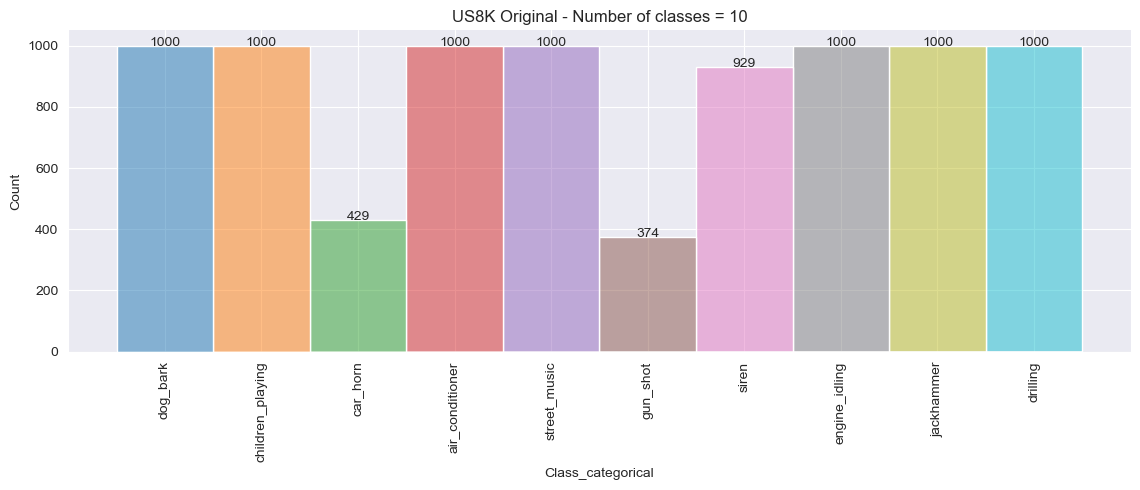

In [41]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Original - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED

* *aug*       = True
* *windowing* = False

Dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly)

ATTENTION: you may need to split this process in more than 2 steps due memory allocation constrains

In [42]:
# For ESC-10 and BDLib2
if opc == 1 or opc == 2:
    
    # Remove silence samples, augment and normalize (windowed) the audio files

    audioPP_output = audioPP(db['Path'].values,
                             db['Class_categorical'].values, 
                             db['Class_OHEV'].values,
                             db['Fold'].values,
                             time_length = time_length,
                             threshold = threshold,
                             aug = True,
                             windowing = False,
                             frames = frames)
    
    X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

    y_OHEV = [np.array(eval(s)) for s in y_OHEV]
    
    db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
    db_aug[['Fold']] = db_aug[['Fold']].astype('str')

    
# For US8K due memory allocation constraints, the process must split the files, delete the variables and join them afterwards.
else:
    
    for i in range(2):
        subset_db = db[int(i*len(db)/2):int((i+1)*len(db)/2)]

        audioPP_output = audioPP(subset_db['Path'].values,
                                 subset_db['Class_categorical'].values, 
                                 subset_db['Class_OHEV'].values,
                                 subset_db['Fold'].values,
                                 time_length = time_length,
                                 threshold = threshold,
                                 aug = True,
                                 windowing = False,
                                 frames = frames)

        X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

        del subset_db # Delete to clear memory

        y_OHEV = [np.array(eval(s)) for s in y_OHEV]

        db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
        db_aug[['Fold']] = db_aug[['Fold']].astype('str')

        del X, y_string, y_OHEV, folds # Delete to clear memory

        # Save db_aug as a pickle file
        with open(os.path.join(path_models, f'db_aug_{i+1}.pkl'), 'wb') as f:
            pickle.dump(db_aug, f)

        del db_aug  # Delete db_aug to clear memory

    # Read and join both db_aug_1 and db_aug_2 into db_aug
    with open(os.path.join(path_models,'db_aug_1.pkl'), 'rb') as f:
        db_aug_1 = pickle.load(f)

    with open(os.path.join(path_models,'db_aug_2.pkl'), 'rb') as f:
        db_aug_2 = pickle.load(f)

    db_aug = pd.concat([db_aug_1, db_aug_2], ignore_index=True)

    del db_aug_1, db_aug_2
    os.remove(os.path.join(path_models,'db_aug_1.pkl'))
    os.remove(os.path.join(path_models,'db_aug_2.pkl'))

100%|██████████████████████████████████████████████████████████████████████████████| 4366/4366 [12:59<00:00,  5.60it/s]
26196it [04:37, 94.41it/s] 


Shape of the audio data..................: (26196, 88200)
Shape of the categorical label data......: (26196,)
Shape of the one hot encoder label data..: (26196,)
Shape of the fold data...................: (26196,)


100%|██████████████████████████████████████████████████████████████████████████████| 4366/4366 [23:18<00:00,  3.12it/s]
26196it [06:32, 66.68it/s] 


Shape of the audio data..................: (26196, 88200)
Shape of the categorical label data......: (26196,)
Shape of the one hot encoder label data..: (26196,)
Shape of the fold data...................: (26196,)


In [43]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [44]:
db_aug['Audio'][random_idx*6] # 6x due augmentation to get the same sample as the original

array([ 0.03946164,  0.0597264 ,  0.05162424, ..., -0.13850276,
       -0.13798895, -0.13035673], dtype=float32)

In [45]:
ipd.Audio(random_sample, rate = SR)

In [46]:
ipd.Audio(db_aug.at[random_idx*6 + 1, 'Audio'], rate = SR) # First augmentation of the original audio

In [47]:
librosa.get_duration(y = db_aug['Audio'][random_idx*6 + 1]) # 6x due augmentation to get the same sample as the original

4.0

In [48]:
pkl_aug_features

'US8K_features_augmented_no_windowing.pkl'

In [49]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_augmented = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_augmented.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_augmented.fillna(0, inplace=True)
    
    # Save the features to a pickle file (ESC-10: ~1,213GB, BDLib2: 1,088GB, US8K: ~21,218GB)
    DB_augmented.to_pickle(os.path.join(path_models, pkl_aug_features))
    
    # Read the features from the pickle file
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_features))

In [50]:
DB_aug_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.121009,0.133490,2094.968187,1745.096817,2886.196035,0.000025,...,-0.023313,0.029888,-0.018669,-0.298720,-0.579663,-0.046785,0.024244,-0.049756,0.759231,-0.024962
1,"[0.000508097463306129, 0.0003710741507293421, -0.0009010079310555599, -0.00033209094377675494, 3.219484096002507e-05...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.116187,0.227206,2588.046498,2086.125856,4064.174268,0.000467,...,-0.016750,0.031165,-0.010229,-0.481762,-0.401758,-0.016346,0.025777,-0.020573,0.212283,-0.767664
2,"[-0.0035122973, -0.0050051752, -0.0045919046, -0.0048774146, -0.0037652655, -0.0022669514, -0.00015891435, 0.0014704...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.100775,0.133033,2106.590578,1777.133904,2892.543974,0.000016,...,-0.049970,0.031053,-0.057323,0.214288,-0.733329,-0.025334,0.031054,-0.028243,0.298586,-0.490271
3,"[-0.003488453, -0.004396054, -0.0037757251, -0.0042094756, -0.0030081559, -0.0015460963, 0.00081547524, 0.0026281716...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.113409,0.135708,2104.516302,1756.504203,2906.857952,0.000055,...,-0.017338,0.024289,-0.014603,-0.185764,-0.548766,0.000113,0.025748,-0.000898,-0.077263,-0.095841
4,"[-0.003237898, -0.0050192326, -0.0046117576, -0.004234772, -0.0019701908, 0.00027243508, 0.0026218973, 0.004221949, ...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.099378,0.171356,2391.238889,1600.176672,3377.165513,0.000008,...,-0.000741,0.026688,-0.001909,-0.054720,-0.604616,0.028016,0.027486,0.031821,-0.303592,0.219901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52387,"[-0.0009879824696155122, 0.000934038778004239, 7.193358775926242e-06, -0.00039526312264830294, -1.2689084422272097e-...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.011075,0.190622,2556.163048,2253.467382,4519.545503,0.029816,...,0.027316,0.027561,0.026955,0.108922,-0.446677,-0.034954,0.044877,-0.024458,-0.525053,-0.874089
52388,"[0.013614702, 0.025402728, 0.023213908, 0.021975169, 0.016956959, 0.015239683, 0.010343045, 0.008701391, 0.006488053...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007441,0.169775,2451.759370,2226.848215,4341.056409,0.014329,...,0.024047,0.031035,0.029566,-0.528228,-0.297265,-0.014086,0.035080,-0.011528,-0.423708,-0.874833
52389,"[0.013724111, 0.025209483, 0.02299475, 0.021716274, 0.016808376, 0.015125214, 0.010314408, 0.008703265, 0.006482009,...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007879,0.172665,2474.068169,2231.898528,4340.309593,0.014456,...,0.023623,0.021582,0.022543,0.224521,0.105888,-0.043505,0.040739,-0.032216,-0.795570,-0.144473
52390,"[0.013087595, 0.025674945, 0.022199064, 0.01882483, 0.014130215, 0.0101510435, 0.0071426327, 0.007999478, 0.01828633...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008052,0.215036,2811.051384,2258.299641,4993.275972,0.010402,...,-0.032974,0.035019,-0.032837,0.005823,-0.685219,-0.000129,0.034881,-0.006539,0.611093,-0.761275


In [51]:
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [52]:
print(len(DB_aug_from_pkl))

52392


In [53]:
DB_aug_from_pkl.shape

(52392, 379)

In [54]:
for i in DB_aug_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


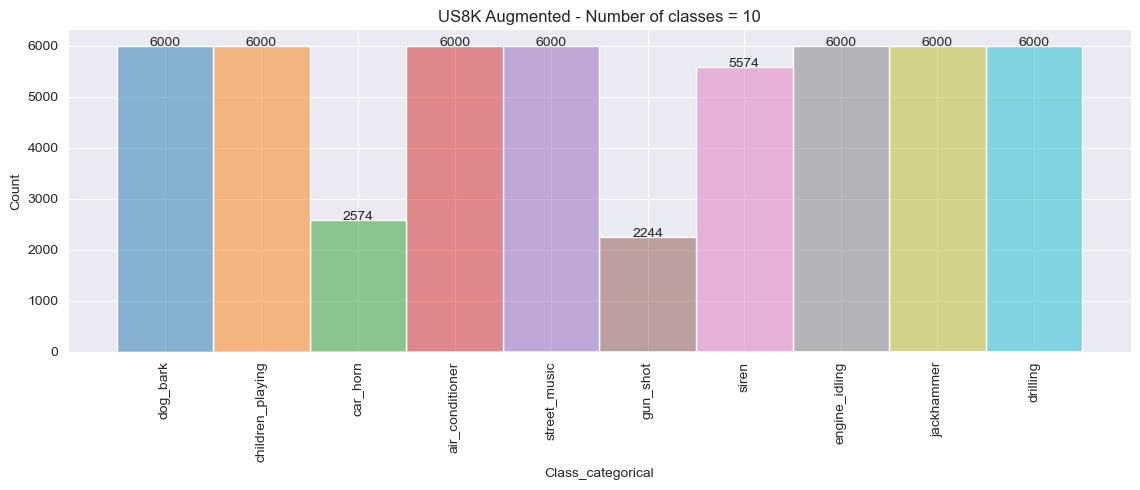

In [55]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

### Features AUGMENTED and WINDOWED

* *aug*       = True (not for US8K)
* *windowing* = True

Check the globals (*aug_set*, *wind_set*) in the beginning of the notebook

Initially, the dataset will be 6x larger (original + time stretching .85 / 1.15, pitch shifting -4 / +4 semitons, and time shifting randomly).

Windowing process depends on the dataset: 9 for ESC-10, 19 for BDLib2, and 7 for USK8K.

Final datasets will have:

* ESC-10 = 6 agumentations * 9  windows * 400 samples   = **21,600 samples**
* BDLib2 = 6 agumentations * 19 windows * 180 samples   = **20,520 samples**
* US8K   = 0 agumentations * 7 window   * 8,732 samples = **61,124 samples**

ATTENTION: you may need to split this process due memory allocation constrains

In [56]:
# Clear the memory
del db_aug, DB_ori_from_pkl, DB_aug_from_pkl

In [57]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP_output = audioPP(db['Path'].values,
                         db['Class_categorical'].values, 
                         db['Class_OHEV'].values,
                         db['Fold'].values,
                         time_length = time_length,
                         threshold = threshold,
                         aug = aug_set,
                         windowing = wind_set,
                         frames = frames)
    
X, y_string, y_OHEV, folds  = audioPP_output.audio_windowed, audioPP_output.labels_cat_wind, audioPP_output.labels_cod_wind, audioPP_output.labels_fold_wind

100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [03:00<00:00, 48.46it/s]
8732it [02:00, 72.48it/s] 
100%|███████████████████████████████████████████████████████████████████████████| 8732/8732 [00:00<00:00, 48387.33it/s]


Shape of the audio data..................: (61124, 22016)
Shape of the categorical label data......: (61124,)
Shape of the one hot encoder label data..: (61124,)
Shape of the fold data...................: (61124,)


In [58]:
y_OHEV = [np.array(eval(s)) for s in y_OHEV]

In [59]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug[['Fold']] = db_aug[['Fold']].astype('str')

In [60]:
print(type(db_aug['Fold'][0]))
print(type(db_aug['Class_OHEV'][0][0]))
print(type(db_aug['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [61]:
ipd.Audio(random_sample, rate = SR)

In [62]:
random_idx

109

In [63]:
# For ESC-10 and BDLib2
print(librosa.get_duration(y = db_aug.at[random_idx * 6 * windowingNo, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 6 * windowingNo + 1, 'Audio'], rate = SR)

0.9984580498866213


In [64]:
# For US8K
print(librosa.get_duration(y = db_aug.at[random_idx * 1 * windowingNo, 'Audio']))
ipd.Audio(db_aug.at[random_idx * 1 * windowingNo, 'Audio'], rate = SR)

0.9984580498866213


In [65]:
pkl_aug_wind_features

'US8K_features_windowed.pkl'

In [66]:
# Extract 375 features from the audio files (long process, strongly dependent on audio duration and its agumentation)

# Check if the pkl file exists, if not, create it
if not os.path.exists(os.path.join(path_models, pkl_aug_wind_features)):
    Ft_extractor = feature_extractor(db_aug)
    DB_aug_wind  = Ft_extractor.DB_aug
    
    # Check for NaN values in the entire DataFrame
    has_nan_columnwise = DB_aug_wind.isna().any(axis=0)

    # Print columns with NaN values
    print("Columns with NaN values:")
    print(has_nan_columnwise[has_nan_columnwise])
    
    DB_aug_wind.fillna(0, inplace=True)
    
    # Save the features to a pickle file (ESC-10: ~2,232GB, BDLib2: ~2,121GB, US8K: ~5,442GB)
    DB_aug_wind.to_pickle(os.path.join(path_models, pkl_aug_wind_features)) 
    
    # Read the features from the pickle file
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

# If exist, read the pkl file with the features extracted
else:
    DB_aug_wind_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))

In [67]:
DB_aug_wind_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.117183,0.129483,2069.471399,1734.789901,2861.958452,0.000172,...,-0.027402,0.036064,-0.027793,-0.105702,-0.542892,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.111724,0.131570,2098.418718,1743.608984,2885.449219,0.000047,...,-0.024680,0.026742,-0.021896,-0.009029,-0.613116,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.124646,0.131459,2096.616414,1747.412264,2877.618963,0.000173,...,-0.022529,0.029269,-0.019908,-0.041418,-0.757713,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.110741,0.131658,2093.378630,1736.615179,2873.214444,0.000026,...,-0.029242,0.026361,-0.024858,-0.293476,-0.509338,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.125728,0.131836,2105.951159,1750.491381,2885.693914,0.000831,...,-0.027311,0.028995,-0.029214,-0.145633,-0.282959,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61119,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.012771,0.165439,2435.099768,2199.072455,4209.741211,0.041714,...,0.022133,0.021647,0.022897,0.105963,-0.457640,-0.066230,0.033488,-0.069738,0.175013,-0.974133
61120,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007954,0.148016,2363.629594,2317.859881,4304.193670,0.055727,...,0.044053,0.014626,0.045769,-0.351788,-0.679147,-0.022097,0.021007,-0.018432,-0.690702,-0.099409
61121,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008383,0.154519,2389.715351,2316.671469,4391.060569,0.036835,...,0.022832,0.013426,0.021000,0.434590,-0.457858,-0.013611,0.021124,-0.016391,-0.028383,-1.071243
61122,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.010459,0.173873,2467.091641,2211.234749,4411.125599,0.021755,...,0.009672,0.011971,0.008398,0.766553,0.517087,-0.012274,0.027106,-0.017513,-0.121982,-0.606880


In [68]:
print(type(DB_aug_wind_from_pkl['Fold'][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_wind_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [69]:
print(len(DB_aug_wind_from_pkl))

61124


In [70]:
DB_aug_wind_from_pkl.shape

(61124, 379)

In [71]:
for i in DB_aug_wind_from_pkl.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


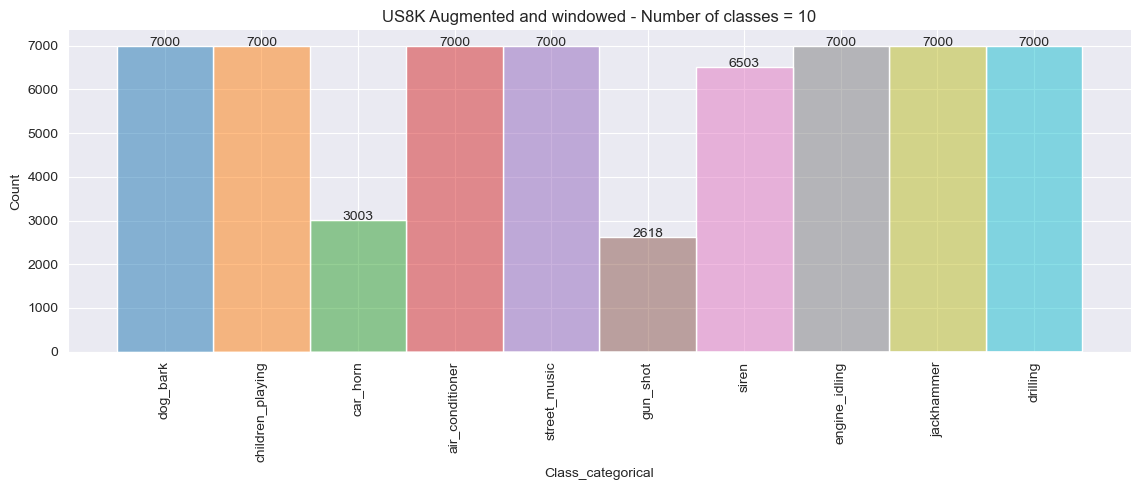

In [72]:
# Analysis of the class balancing

sns.set_style("darkgrid")
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
gTitle = nom_dataset + ' Augmented and windowed - Number of classes = ' + str(len(pd.Series(DB_aug_wind_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_wind_from_pkl, x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

## Features analysis

In [73]:
DB_ori_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_features))

In [74]:
# Method to parse each row and extract the defined audio feature

def MFCC_parser(row): 
    # Number of MFCCs
    n_mfcc = 13
   
    # 13 x frames matrix
    mfcc = librosa.feature.mfcc(y = row.Audio, sr = SR, n_mfcc = n_mfcc)
    for i in range(0, n_mfcc):
        row[f'MFCC_{i+1}'] = np.array(mfcc[i])
  
    return row

In [75]:
# Method to parse each row and extract the defined audio feature

def TONNETZ_parser(row): 

    # 6 x frames matrix
    tonnetz    = librosa.feature.tonnetz(y = librosa.effects.harmonic(row.Audio), sr = SR)
    tonnetz_sp = np.shape(tonnetz)
    for i in range(0, tonnetz_sp[0]):
        row[f'TONNETZ_{i+1}'] = np.array(tonnetz[i])    

    return row

In [76]:
# Method to parse each row and extract the defined audio feature

def MEL_parser(row): 
    # Number of MELs    
    n_mels = 128

    # 128 x frames matrix
    mel = librosa.feature.melspectrogram(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR, n_mels = n_mels)
    for i in range(0, n_mels):
        row[f'MEL_{i+1}'] = np.array(mel[i])

    return row

In [77]:
# Method to parse each row and extract the defined audio feature

def CONTRAST_parser(row): 

    # 7 x frames matrix
    spec_contrast    = librosa.feature.spectral_contrast(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR)
    spec_contrast_sp = np.shape(spec_contrast)
    for i in range(0, spec_contrast_sp[0]):
        row[f'CONSTRAST_{i+1}'] = np.array(spec_contrast[i])

    return row

In [78]:
# Method to parse each row and extract the defined audio feature

def CHROMA_parser(row): 

    # 12 x frames matrix
    chroma    = librosa.feature.chroma_stft(y = row.Audio, hop_length = HOP_LENGTH, n_fft = 2048, sr = SR)
    chroma_sp = np.shape(chroma)
    for i in range(0, chroma_sp[0]):
        row[f'CHROMA_{i+1}'] = np.array(chroma[i])

    return row

In [79]:
MFCC_columns      = list(DB_ori_from_pkl.filter(regex='MFCC_\d', axis=1).columns)
TONNETZ_columns   = list(DB_ori_from_pkl.filter(regex='^TONNETZ_\d', axis=1).columns)
MEL_columns       = list(DB_ori_from_pkl.filter(regex='^MEL_\d', axis=1).columns)
CONSTRAST_columns = list(DB_ori_from_pkl.filter(regex='^CONSTRAST_\d', axis=1).columns)
CHROMA_columns    = list(DB_ori_from_pkl.filter(regex='^CHROMA_\d', axis=1).columns)

In [80]:
def plot_MFCC_features(feature_def, lin: int, columns: list):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    dfSample = pd.DataFrame(DB_ori_from_pkl[lin:lin+1]).apply(feature_def, axis = 1)
    sample   = str(DB_ori_from_pkl.at[lin, 'Class_categorical'])

    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(columns)))
    plt.title(f'{nom_dataset} - MFCCs distribution across frames of a single audio file, class: {sample}')
    plt.savefig(os.path.join(path_pic, picture_name))

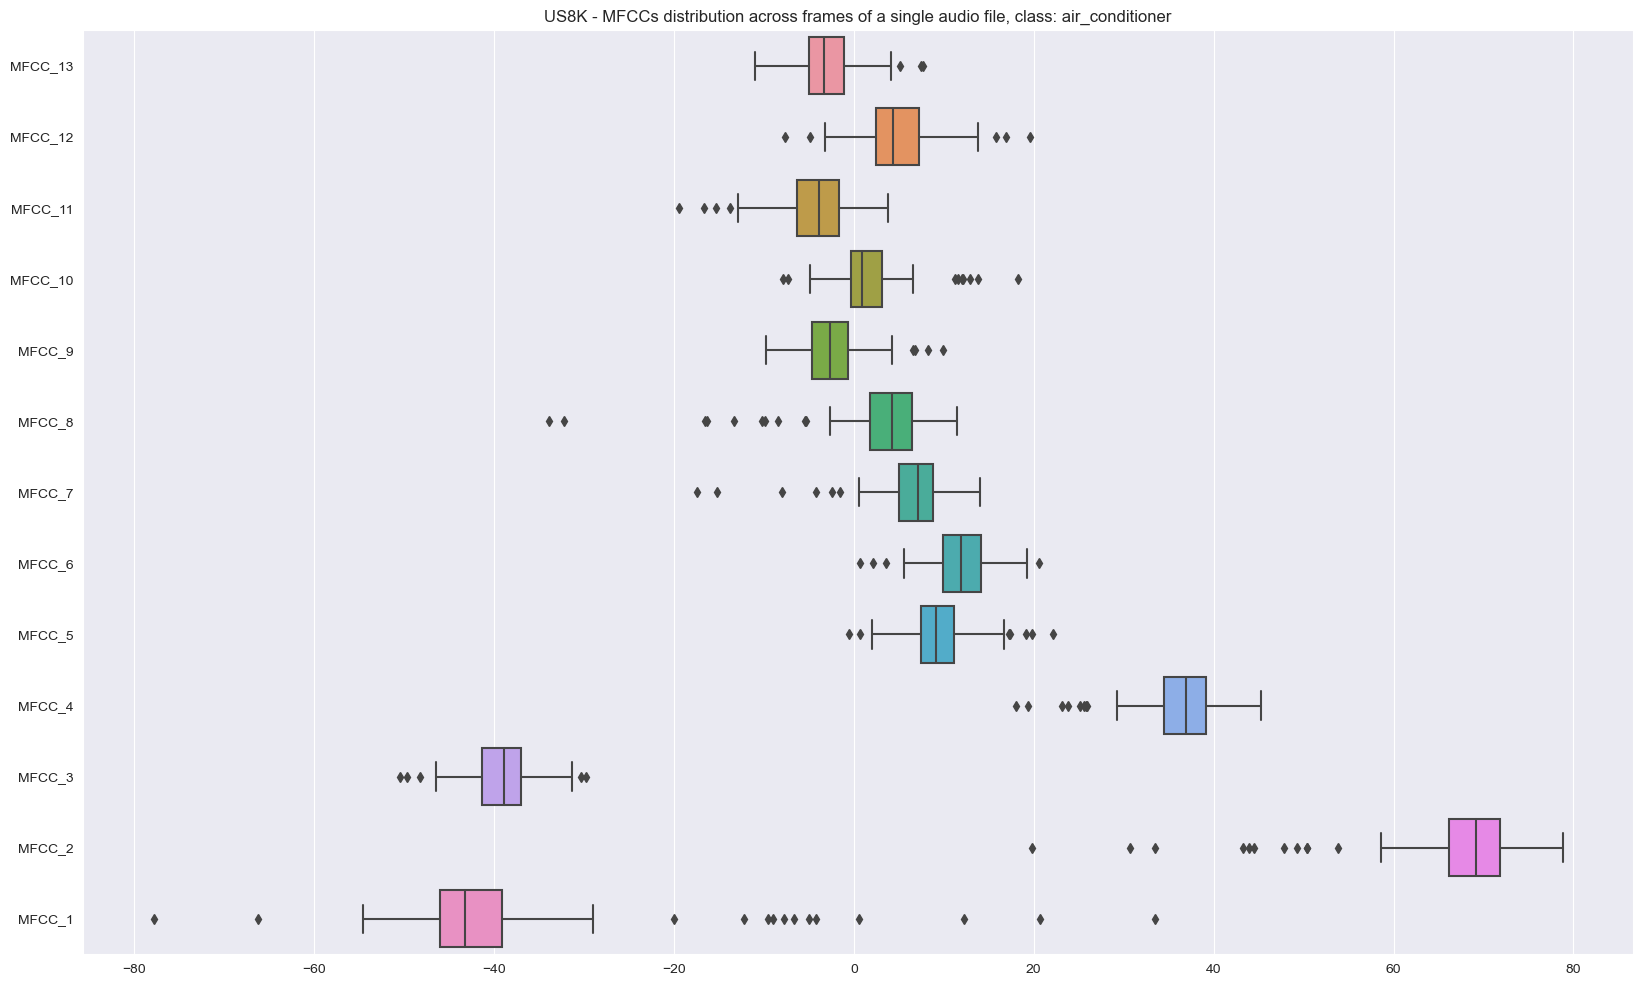

In [81]:
plot_MFCC_features(MFCC_parser, 50, MFCC_columns)

In [82]:
DB_ori_from_pkl['Class_categorical']

0               dog_bark
1       children_playing
2       children_playing
3       children_playing
4       children_playing
              ...       
8727            car_horn
8728            car_horn
8729            car_horn
8730            car_horn
8731            car_horn
Name: Class_categorical, Length: 8732, dtype: object

In [83]:
dfTONNETZ   = DB_ori_from_pkl.filter(regex=r'^TONNETZ_\d', axis=1)
dfMEL       = DB_ori_from_pkl.filter(regex=r'^MEL_\d', axis=1)
dfCONSTRAST = DB_ori_from_pkl.filter(regex=r'^CONTRAST_\d', axis=1)
dfCHROMA    = DB_ori_from_pkl.filter(regex=r'^CHROMA_\d', axis=1)
dfMFCC      = DB_ori_from_pkl.filter(regex=r'^MFCC_\d', axis=1)

In [84]:
dfTONNETZ.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMEL.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCONSTRAST.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfCHROMA.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])
dfMFCC.insert(0, 'Class_categorical', DB_ori_from_pkl['Class_categorical'])

In [85]:
def plot_features(db: pd.DataFrame, feature_name:str, lin:int):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    sample   = str(db.at[lin, 'Class_categorical'])
    dfSample = db.drop(columns=['Class_categorical'])
    
    f = plt.figure(figsize=(20, 12))
    sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])), orient = "h", order=list(reversed(dfSample.columns)))
    plt.title(f'{nom_dataset} - {feature_name} distribution across frames of a single audio file, class: {sample}')
    plt.savefig(os.path.join(path_pic, picture_name))

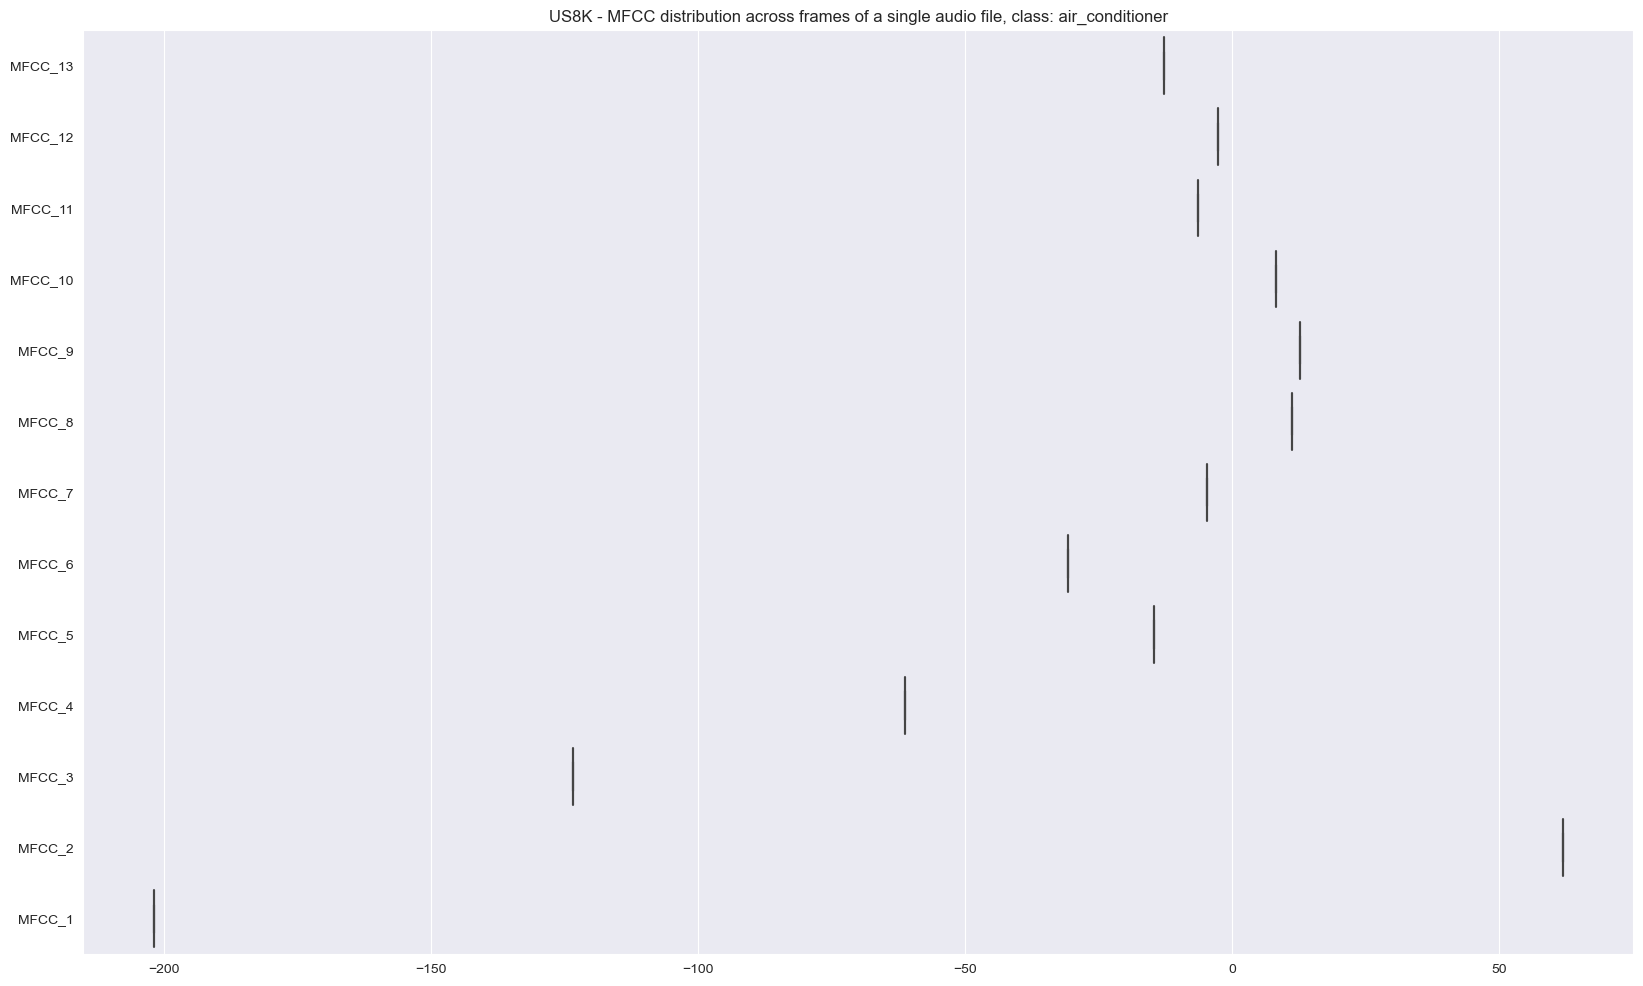

In [86]:
plot_features(dfMFCC, 'MFCC', 50)

In [87]:
audio_samples = DB_ori_from_pkl.groupby('Class_categorical')['Audio'].apply(lambda s: s.sample(1))
sampled_indices = np.array(audio_samples.index)
sampled_indices

# Convert the resulting Series to a DataFrame and reset the index
#temp_sample_df = audio_samples.reset_index()

# Convert the DataFrame to a NumPy array
#plot_samples   = temp_sample_df[['Class_categorical', 'Audio']].values
#plot_samples

array([('air_conditioner', 79), ('car_horn', 6408),
       ('children_playing', 4617), ('dog_bark', 839), ('drilling', 2357),
       ('engine_idling', 3672), ('gun_shot', 7937), ('jackhammer', 4374),
       ('siren', 6380), ('street_music', 5238)], dtype=object)

In [88]:
DB_ori_from_pkl.at[120,'Class_categorical']

'siren'

In [89]:
sampled_indices.shape[0]

10

In [90]:
# Plot the MFCC features of each class sample
    
def plot_MFCC_audio_sample(data: list):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    fig, axes = plt.subplots(int(np.ceil(np.shape(data)[0] / 2)), 2, 
                             figsize=(20, (np.ceil(data.shape[0] / 2))*6),
                            layout='constrained')
    fig.suptitle(f'{nom_dataset} - MFCC features for each class sample', fontsize = 14)
    fig.subplots_adjust(top=0.9, hspace=0.1)

    for i, ax in enumerate(axes.flatten()):
        if i < np.shape(data)[0]:
            
            dfSample = pd.DataFrame(DB_ori_from_pkl[data[i][1]:data[i][1]+1]).apply(MFCC_parser, axis = 1)
            sample   = data[i][0]

            img = sns.boxplot(dfSample.apply(lambda x: pd.Series(x.values[0])),
                              ax     = ax,
                              orient = "h", 
                              order  = list(reversed(MFCC_columns)))
            ax.set_title(f'Sample {i+1}, class {sample}') 

        else:
            ax.axis('off') 
            
    fig.tight_layout(pad = 2.0)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

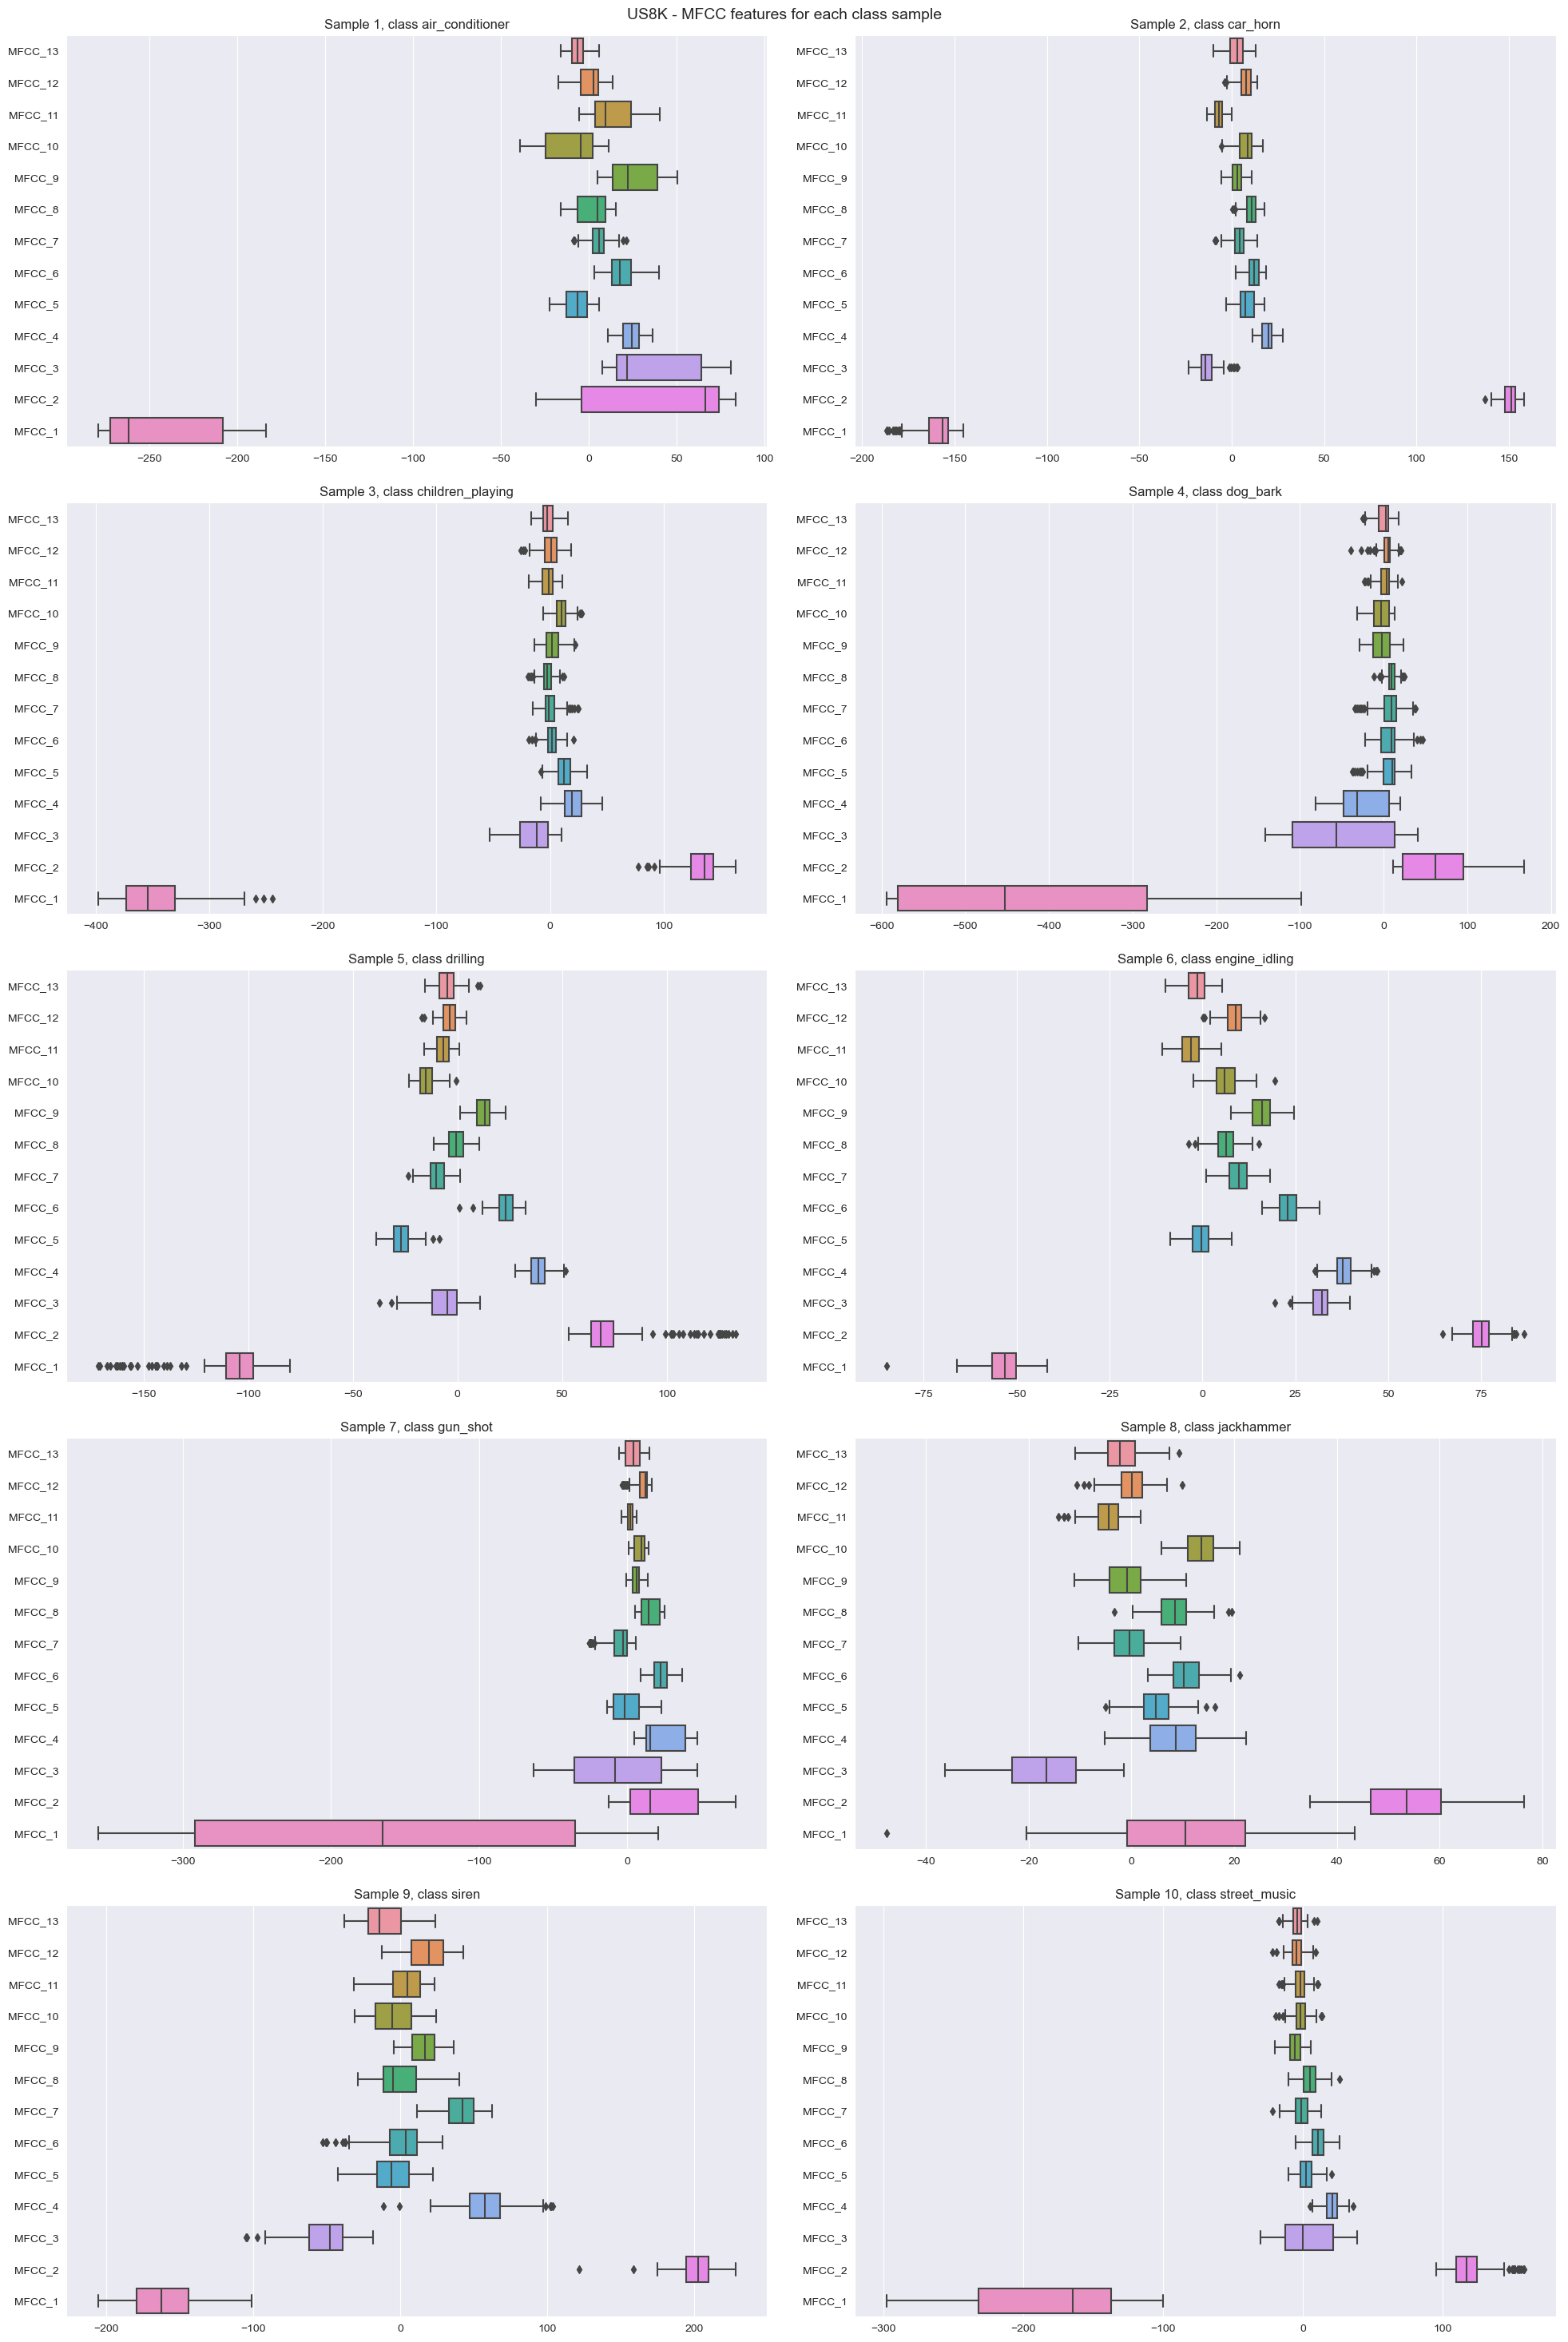

In [91]:
plot_MFCC_audio_sample(sampled_indices)

In [92]:
# Group by the class and get one random sample of each class
k = DB_ori_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical      
air_conditioner    2894    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
car_horn           7687    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   3102    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           1225    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
drilling           7186    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
engine_idling      501     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
gun_shot           6505    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
jackhammer         390     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
siren              2021    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
street_music       7845    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'air_conditioner': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'drilling': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'engine_idling': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'gun_shot': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'jackhammer': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'siren': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'street_music': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [93]:
nom_classes = list(encoder_dict.keys())
nom_classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

# End of notebook